# Separate pedestrians to test and train according to start point in 5x5 grid

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
FRAME_WIDTH = 1920
FRAME_HEIGHT = 1080

After useless pedestrian removal amount changed and numeration now starts from 0 not 1

In [6]:
# in annotation names of files look like "000010.txt"
# so we need to adjust strings while converting them from floats
ZERO_PADDING = 6
NUMBER_OF_PEDESTRIANS = 12273

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

def download_pedestrian(index):
    error_message_template = "Pedestrian number should be between 0 and {max}; given number: {id}"
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), error_message_template.format(max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

We will give every pedestrian label which depends on pedestrian's start point.

Let's save label, number of frames and category of pedestrian: test or train.

In [7]:
w = FRAME_WIDTH / 5
h = FRAME_HEIGHT / 5

labels = []
number_of_frames = []

for index in range(NUMBER_OF_PEDESTRIANS):
    data = download_pedestrian(index)
    
    number_of_frames.append(int(data.shape[0]))
    
    start_coordinate = data[:1]
    i = int(start_coordinate['X'] / w) + 1
    j = int(start_coordinate['Y'] / h)
    labels.append(j * 5 + i)

In [8]:
from sklearn.cross_validation import StratifiedShuffleSplit

labels = np.array(labels)
sss = StratifiedShuffleSplit(labels, test_size=1/6, n_iter=1)

for train, test in sss:
    train_indeces = train
    test_indeces = test

In [9]:
category = []

for index in range(NUMBER_OF_PEDESTRIANS):
    category.append('train' if index in train_indeces else 'test')

In [10]:
data = pd.DataFrame({'label': pd.Series(labels, index=range(1, NUMBER_OF_PEDESTRIANS + 1)),
                     'category': pd.Series(category, index=range(1, NUMBER_OF_PEDESTRIANS + 1)),
                     'frames_number': pd.Series(number_of_frames, index=range(1, NUMBER_OF_PEDESTRIANS + 1))})

In [11]:
data.to_csv('src/pedestrian_labels_and_test_and_train_separation.csv')

In [14]:
data['frames_number'].mean(), data['frames_number'].min(), data['frames_number'].max()

(36.95486026236454, 10, 995)

In [15]:
len(train_indeces), len(test_indeces)

(10224, 2049)

In [20]:
data[data['category'] == 'train']['frames_number'].mean(), data[data['category'] == 'test']['frames_number'].mean(),

(36.951388888888886, 36.972181551976576)

So we can see that mean amount of frames is almost equal in test and train sets

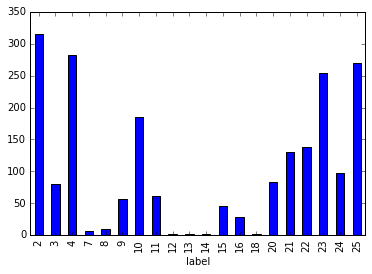

In [41]:
data[data['category'] == 'test'].groupby(['label'])['frames_number'].count().plot.bar()

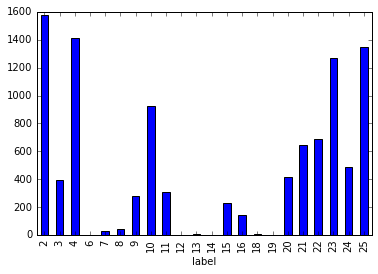

In [42]:
data[data['category'] == 'train'].groupby(['label'])['frames_number'].count().plot.bar()